In [1]:
from pathlib import Path
from typing import Sequence

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import skimage
from einops import rearrange
from tqdm import tqdm


pv.set_jupyter_backend("static")

datadir = Path("../data/SIM")


def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


In [2]:
data_full, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
print(pixel_sizes)
data = data_full[..., 1200:2000, 0:800]
data_chunks = rearrange(data, "C Z (Ny Y) (Nx X) -> (Ny Nx) C Z Y X", Ny=1, Nx=1)
data = data_chunks[0]

[0.12593877 0.01565149 0.01565149]


In [3]:
data.shape

(2, 45, 800, 800)

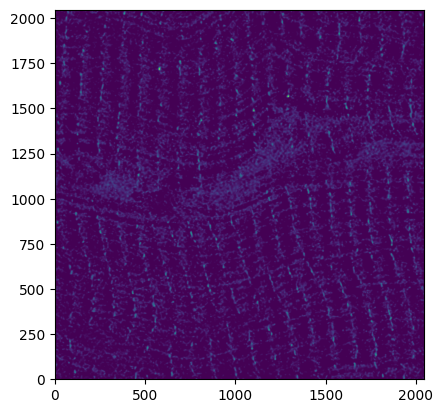

In [4]:
plt.imshow(np.max(data_full[1], axis=0), origin="lower")

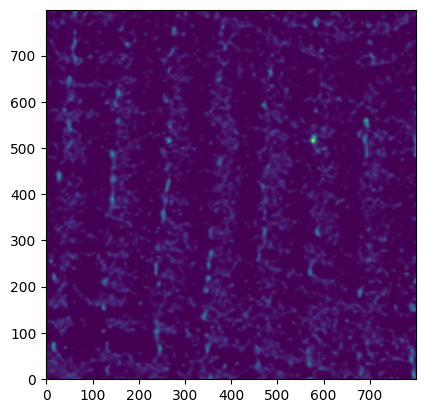

In [5]:
plt.imshow(np.max(data[1], axis=0), origin="lower")

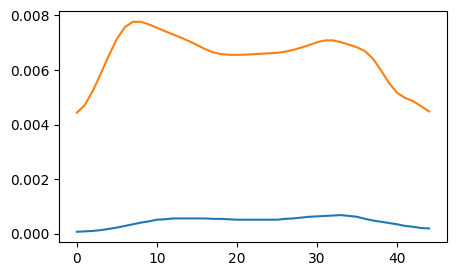

In [6]:
q = np.quantile(data, 0.7, axis=(-1, -2))
m = np.mean(data, axis=(-1, -2))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(q[0])
ax.plot(m[0])

In [7]:
kernel_size = (data[0].shape[0] // 10, data[0].shape[1] // 5, data[0].shape[2] // 5)
clip_limit = 0.03
data_equalized = [
    skimage.exposure.equalize_adapthist(d, kernel_size, clip_limit) for d in data
]

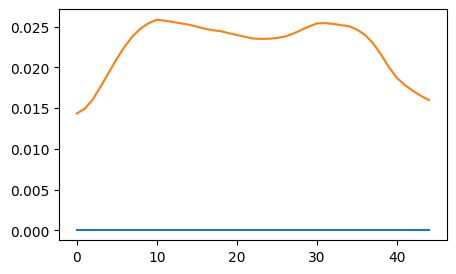

In [8]:
q = np.quantile(data_equalized, 0.7, axis=(-1, -2))
m = np.mean(data_equalized, axis=(-1, -2))

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(q[0])
ax.plot(m[0])

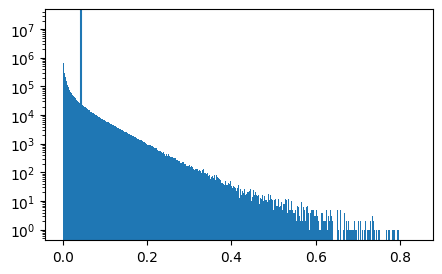

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[0][:].flatten(), bins=1000)
# ax.set_yscale("log")
ax.axvline(skimage.filters.threshold_otsu(data[1, :]))
ax.set_yscale("log")

In [10]:
thresholds

NameError: name 'thresholds' is not defined

In [10]:
data = data_equalized

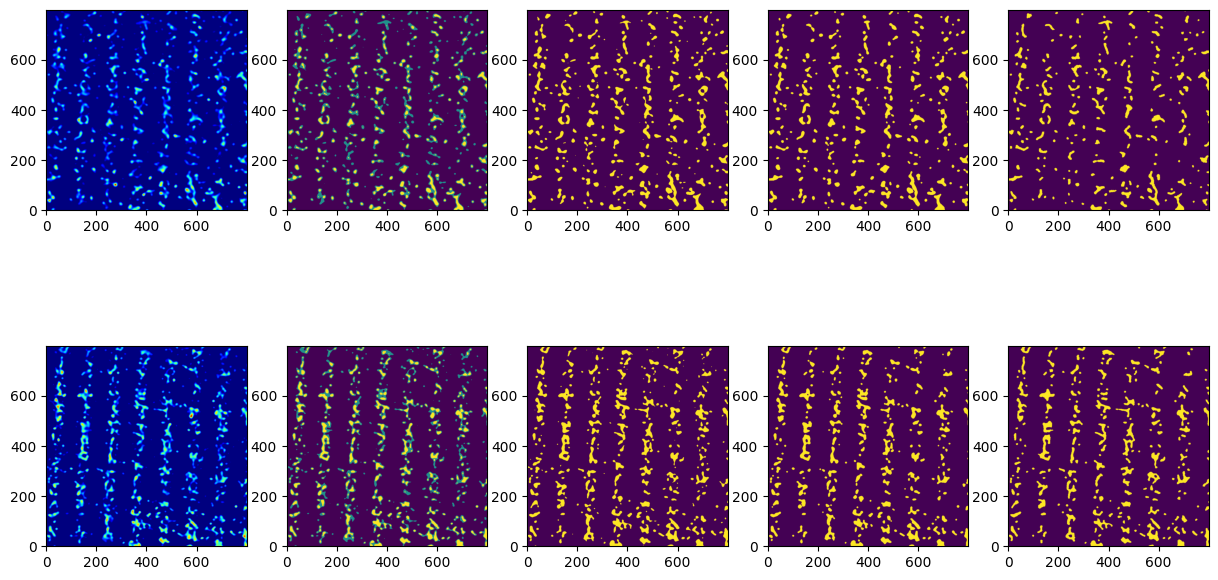

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
z_ind = 10
for i, axes_row in enumerate(axes):
    # img = data[i]
    # p2, p98 = np.percentile(img[z_ind], (2, 98))
    # # z_slice = skimage.exposure.rescale_intensity(img[z_ind], in_range=(p2, p98))
    # z_slice = skimage.exposure.equalize_adapthist(img[z_ind], clip_limit=0.2)
    z_slice = data_equalized[i][z_ind]
    thresholds = skimage.filters.threshold_multiotsu(z_slice)
    bin = z_slice > skimage.filters.threshold_otsu(z_slice)
    # seg = skimage.segmentation.morphological_chan_vese(
    #     img, num_iter=40, init_level_set=img > thresholds[0], smoothing=1
    # )
    markers = np.zeros_like(z_slice, dtype=np.int_)
    markers[z_slice <= thresholds[0]] = 1
    markers[z_slice > thresholds[1]] = 2
    elevation_map = skimage.filters.sobel(z_slice)
    seg = skimage.segmentation.watershed(elevation_map, markers)
    axes_row[0].imshow(z_slice, cmap="jet", origin="lower")
    axes_row[1].imshow(np.digitize(z_slice, bins=thresholds), origin="lower")
    axes_row[2].imshow(bin, origin="lower")
    axes_row[3].imshow(
        skimage.morphology.binary_opening(bin, skimage.morphology.disk(3)),
        origin="lower",
    )
    axes_row[4].imshow(seg, origin="lower")


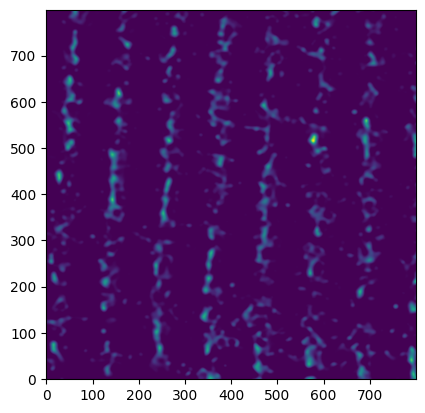

In [13]:
plt.imshow(np.mean(data_equalized[1][0:12], axis=0), origin="lower")

(800, 800)


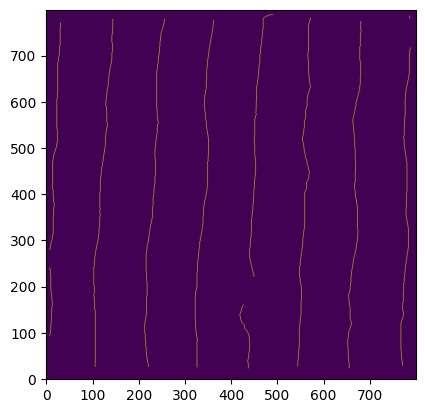

In [12]:
img = np.mean(data_equalized[1][0:12], axis=0)
img = skimage.filters.gaussian(img, 20)
img = skimage.filters.prewitt_v(img)
print(img.shape)
img = img >= skimage.filters.threshold_otsu(img)
img = skimage.morphology.binary_opening(img, skimage.morphology.disk(20))
# h, theta, d = skimage.transform.hough_line(img, theta=np.linspace(0, np.pi / 4, 50))
skele = skimage.morphology.skeletonize(img, method="lee")
# plt.imshow(img, origin="lower")
plt.imshow(skele, origin="lower")
# for _, angle, dist in zip(*skimage.transform.hough_line_peaks(h, theta, d)):
#     (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
#     plt.axline((x0, y0), slope=np.tan(angle + np.pi / 2))

In [207]:
scndimage.distance_transform_edt(np.logical_not(skele))

array([[93.34345183, 93.26306879, 93.1933474 , ..., 39.62322551,
        40.31128874, 41.01219331],
       [92.34717104, 92.26592004, 92.19544457, ..., 38.89730068,
        39.59797975, 40.31128874],
       [91.35097153, 91.26883367, 91.19758769, ..., 38.18376618,
        38.89730068, 39.62322551],
       ...,
       [41.10960958, 40.36087214, 39.62322551, ..., 16.97056275,
        17.69180601, 18.43908891],
       [41.77319715, 41.03656906, 40.31128874, ..., 17.69180601,
        18.38477631, 19.10497317],
       [42.44997055, 41.72529209, 41.01219331, ..., 18.43908891,
        19.10497317, 19.79898987]], shape=(800, 800))

In [151]:
distance_map = scndimage.distance_transform_edt(np.logical_not(skele))

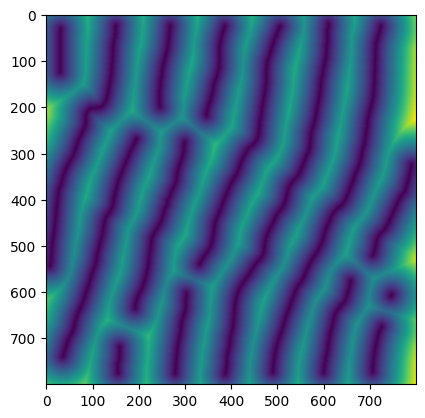

In [150]:
plt.imshow(scndimage.distance_transform_edt(np.logical_not(skele)))

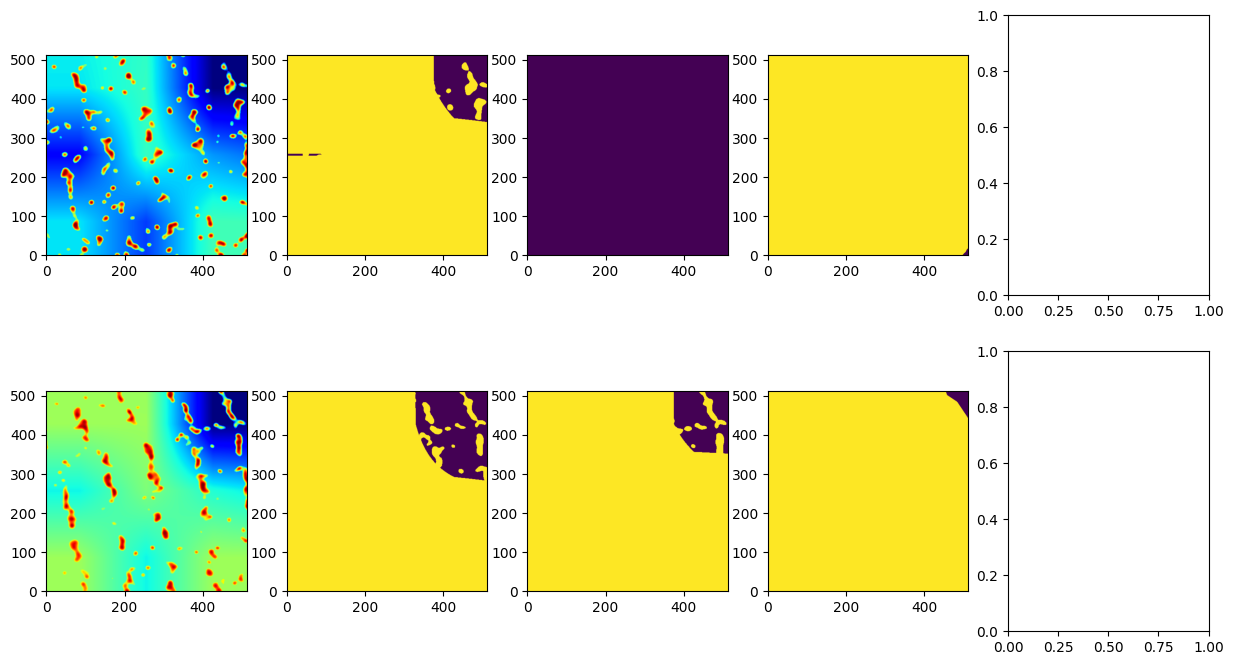

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
z_ind = 0
for i, axes_row in enumerate(axes):
    img = data[i]
    threshold = skimage.filters.threshold_otsu(img)
    bin = skimage.filters.apply_hysteresis_threshold(img, 0.75 * threshold, threshold)
    seg = skimage.segmentation.morphological_chan_vese(
        img[z_ind],
        num_iter=50,
        init_level_set=img[z_ind],
        smoothing=1,
    )

    axes_row[0].imshow(img[z_ind], cmap="jet", origin="lower")
    axes_row[1].imshow(img[z_ind] >= 1.0 * threshold, origin="lower")
    axes_row[2].imshow(bin[z_ind], origin="lower")
    axes_row[3].imshow(seg, origin="lower")
    # axes_row[4].imshow(seg[10] - bin[10])


In [163]:
seg.shape

(512, 512)

In [78]:
pixel_sizes / np.min(pixel_sizes)

array([8.046441, 1.      , 1.      ], dtype=float32)

In [79]:
out = skimage.transform.rescale(
    data[0], scale=pixel_sizes / np.min(pixel_sizes), order=1
)

In [80]:
out.shape

(362, 512, 512)

In [13]:
from tqdm import tqdm


# img_desmin, img_actinin = data[0], data[1]

img_desmin = skimage.transform.rescale(
    data_equalized[0][0:12], scale=pixel_sizes / np.min(pixel_sizes), order=1
)
img_actinin = skimage.transform.rescale(
    data_equalized[1][0:12], scale=pixel_sizes / np.min(pixel_sizes), order=1
)


def binarize_zstack(img):
    def binarize_z_slice(z_slice):
        # thresholds = skimage.filters.threshold_multiotsu(z_slice)
        # markers = np.zeros_like(z_slice, dtype=np.int_)
        # markers[z_slice <= thresholds[0]] = 1
        # markers[z_slice > thresholds[1]] = 2
        # elevation_map = skimage.filters.sobel(z_slice)
        # seg = skimage.segmentation.watershed(elevation_map, markers)
        # return seg - 1
        bin = z_slice >= skimage.filters.threshold_otsu(z_slice)
        return skimage.morphology.binary_opening(bin, skimage.morphology.disk(3))

    return np.stack([binarize_z_slice(z_slice) for z_slice in tqdm(img)], axis=0)


desmin_segmented = rearrange(binarize_zstack(img_desmin), "z y x -> x y z")
actinin_segmented = rearrange(binarize_zstack(img_actinin), "z y x -> x y z")
# otsu = skimage.filters.threshold_otsu(img)
# actinin_segmented = skimage.filters.apply_hysteresis_threshold(img, 0.7 * otsu, otsu)


100%|██████████| 97/97 [00:04<00:00, 22.10it/s]


In [114]:
img_desmin.shape

(362, 512, 512)

(array([ 1.,  0.,  0.,  0.,  0., 13.,  0.,  4.,  2.,  0.,  0.,  0.,  3.,
         0.,  0.,  2.,  0.,  3.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,
         2.,  0.,  1.,  1.,  1.,  0.,  5.,  2.,  1.,  2.,  3.,  5.,  5.,
         5.,  1.,  4.,  4.,  5.,  4.,  5.,  4.,  5.,  9.,  8.,  8.,  2.,
         5.,  9.,  5.,  9.,  6.,  4., 12.,  7.,  6.,  9.,  4.,  7.,  8.,
         4.,  8., 10.,  4.,  6.,  5.,  5.,  3.,  6.,  5.,  4.,  7.,  4.,
         4.,  5.,  8.,  8.,  2.,  2.,  7.,  2.,  5.,  5.,  6.,  0.,  2.,
         4.,  0.,  2.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([1.25527251, 1.29534016, 1.33540781, 1.37547547, 1.41554312,
        1.45561078, 1.49567843, 1.53574609, 1.57581374, 1.6158814 ,
        1.65594905, 1.6960167 , 1.73608436, 1.77615201, 1.81621967,
        1.85628732, 1.89635498, 1.93642263, 1.97649029, 2.01655794,
        2.0566256 , 2.09669325, 2.1367609 , 2.17682856, 2.21689621,
        2.25696387, 2.29703152, 2.33709918, 2.37716683, 2.41723449,
        2.45730214, 2.4973

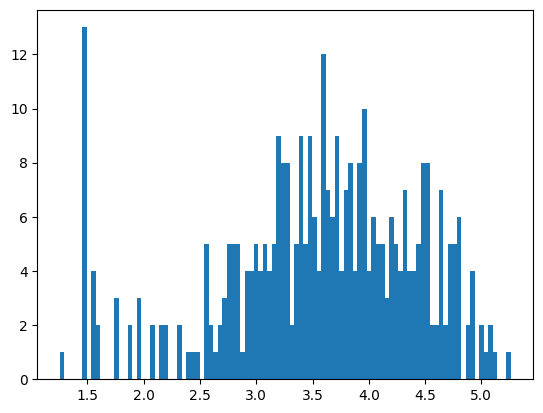

In [15]:
labels = skimage.measure.label(desmin_segmented)
comp_sizes = [np.sum(labels == i) for i in np.unique(labels) if i != 0]
plt.hist(np.log10(comp_sizes), bins=100)

In [16]:
import scipy.ndimage as scndimage


obj = scndimage.find_objects(labels)

In [17]:
def slice_range(slice_: slice) -> int:
    return slice_.stop - slice_.start


z_lengths = [slice_range(o[2]) for o in obj]

(array([ 1.,  0.,  0.,  0.,  0., 13.,  0.,  4.,  2.,  0.,  0.,  0.,  3.,
         0.,  0.,  2.,  0.,  3.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  0.,
         2.,  0.,  1.,  1.,  1.,  0.,  5.,  2.,  1.,  2.,  3.,  5.,  5.,
         5.,  1.,  4.,  4.,  5.,  4.,  5.,  4.,  5.,  9.,  8.,  8.,  2.,
         5.,  9.,  5.,  9.,  6.,  4., 12.,  7.,  6.,  9.,  4.,  7.,  8.,
         4.,  8., 10.,  4.,  6.,  5.,  5.,  3.,  6.,  5.,  4.,  7.,  4.,
         4.,  5.,  8.,  8.,  2.,  2.,  7.,  2.,  5.,  5.,  6.,  0.,  2.,
         4.,  0.,  2.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([1.25527251, 1.29534016, 1.33540781, 1.37547547, 1.41554312,
        1.45561078, 1.49567843, 1.53574609, 1.57581374, 1.6158814 ,
        1.65594905, 1.6960167 , 1.73608436, 1.77615201, 1.81621967,
        1.85628732, 1.89635498, 1.93642263, 1.97649029, 2.01655794,
        2.0566256 , 2.09669325, 2.1367609 , 2.17682856, 2.21689621,
        2.25696387, 2.29703152, 2.33709918, 2.37716683, 2.41723449,
        2.45730214, 2.4973

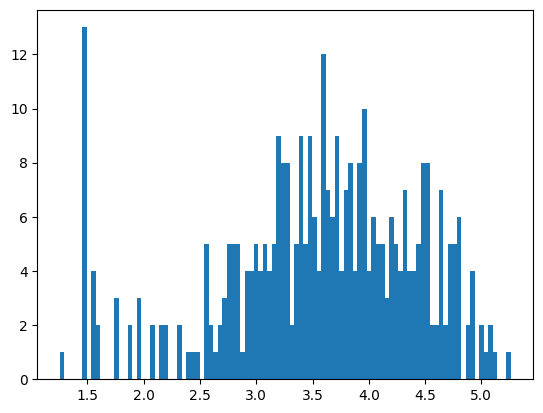

In [18]:
plt.hist(np.log10(comp_sizes), bins=100)

(array([ 20.,   7.,   2.,   5.,   1.,   0.,   2.,   2.,   0.,   3.,   3.,
          4.,   5.,   7.,   2.,   3.,   4.,   2.,   7.,   8.,   0.,   3.,
          6.,   3.,   0.,   2.,   5.,   0.,   3.,   7.,   8.,   3.,   6.,
          7.,   2.,   6.,   0.,   1.,   3.,   3.,   1.,   4.,   0.,   6.,
          1.,   2.,   1.,   4.,   1.,   0.,   1.,   2.,   5.,   3.,   4.,
          4.,   4.,   1.,   4.,   1.,   4.,   1.,   3.,   1.,   3.,   1.,
          2.,   1.,   1.,   2.,   2.,   2.,   2.,   0.,   0.,   3.,   0.,
          5.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   1.,   2.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,
        109.]),
 array([ 1.  ,  1.96,  2.92,  3.88,  4.84,  5.8 ,  6.76,  7.72,  8.68,
         9.64, 10.6 , 11.56, 12.52, 13.48, 14.44, 15.4 , 16.36, 17.32,
        18.28, 19.24, 20.2 , 21.16, 22.12, 23.08, 24.04, 25.  , 25.96,
        26.92, 27.88, 28.84, 29.8 , 30.76, 31.72, 32.68, 33.64, 34.6 ,
        35.56, 36.52, 37.48, 38.44

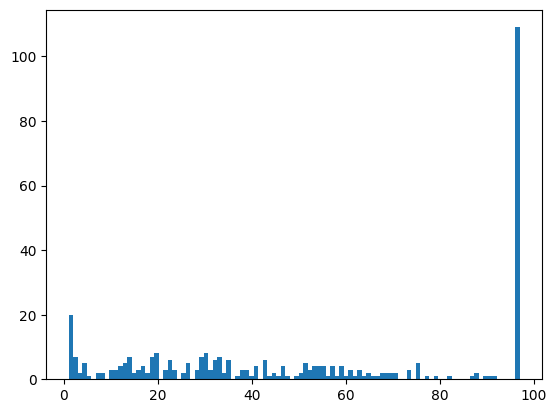

In [19]:
plt.hist(z_lengths, bins=100)

In [20]:
dists = [
    distance_map[int((o[0].start + o[0].stop) / 2), int((o[1].start + o[1].stop) / 2)]
    for o in obj
]

NameError: name 'distance_map' is not defined

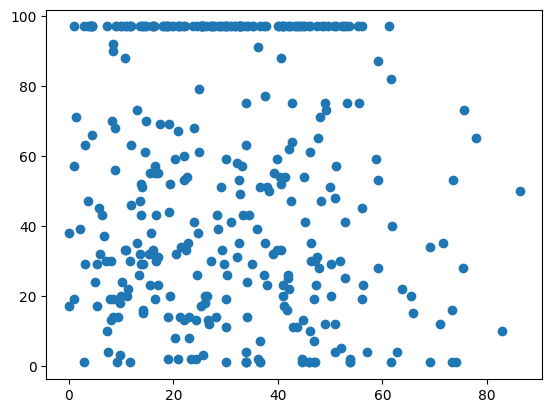

In [ ]:
plt.scatter(dists, z_lengths)

In [ ]:
cms = [
    scndimage.center_of_mass(desmin_segmented, lb) for lb in tqdm(np.unique(labels)[1:])
]

 27%|██▋       | 97/353 [05:12<13:45,  3.23s/it]


KeyboardInterrupt: 

In [ ]:
from itertools import product


distances = []
z_spans = []
for i, j in tqdm(
    product(range(desmin_segmented.shape[0]), range(desmin_segmented.shape[1]))
):
    dist_to_zline = distance_map[i, j]
    segmented_line = desmin_segmented[i, j]
    if np.any(segmented_line):
        objs = scndimage.find_objects(scndimage.label(segmented_line)[0])
        for o in objs:
            z_spans.append(slice_range(o[0]))
            distances.append(dist_to_zline)


640000it [00:09, 68445.04it/s] 


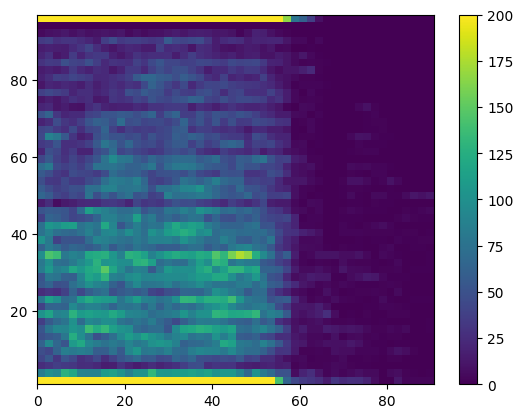

In [219]:
plt.hist2d(distances, z_spans, bins=50, vmax=200)
plt.colorbar()

In [ ]:
scndimage.label(desmin_segmented[i, j])[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 1)

In [178]:
scndimage.find_objects(scndimage.label(desmin_segmented[i, j])[0])

[(slice(51, 63, None),)]

In [173]:
desmin_segmented[0, 6]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [162]:
img_1d = np.ones(10)
img_1d[5:9] = 0
scndimage.label(img_1d)

(array([1, 1, 1, 1, 1, 0, 0, 0, 0, 2], dtype=int32), 2)

In [ ]:
cms = np.stack(cms, axis=0)

(np.float64(321.72367916203046),
 np.float64(412.08748673087007),
 np.float64(52.59352018826178))

In [21]:
np.min(actinin_segmented)

np.int64(-1)

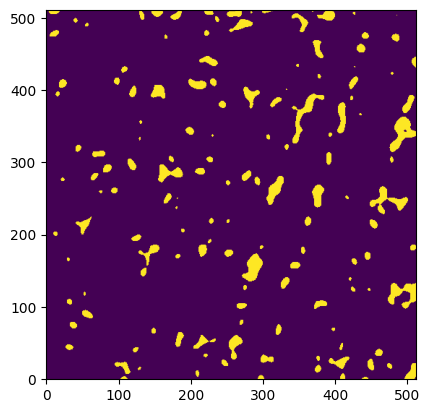

In [19]:
plt.imshow(actinin_segmented[..., 60], origin="lower")

In [14]:
actinin_segmented = skimage.morphology.remove_small_objects(
    actinin_segmented, min_size=500
)
desmin_segmented = skimage.morphology.remove_small_objects(
    desmin_segmented, min_size=500
)

In [15]:
verts, faces, normals, values = skimage.measure.marching_cubes(
    actinin_segmented,
    level=0.5,
    spacing=np.ones_like(pixel_sizes) * np.min(pixel_sizes),
)
mesh_actinin = pv.PolyData.from_regular_faces(verts, faces)

verts, faces, normals, values = skimage.measure.marching_cubes(
    desmin_segmented,
    level=0.5,
    spacing=np.ones_like(pixel_sizes) * np.min(pixel_sizes),
)
mesh_desmin = pv.PolyData.from_regular_faces(verts, faces)

In [23]:
verts.shape

(1766150, 3)

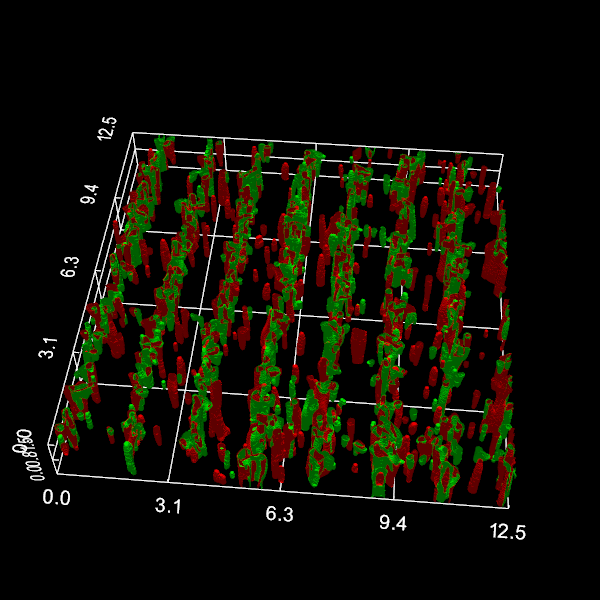

In [17]:
mesh = pv.PolyData.from_regular_faces(verts, faces)

pl = pv.Plotter(notebook=True, window_size=(600, 600))
pl.add_mesh(
    mesh_desmin,
    color="#FF0000",
    show_scalar_bar=False,
)

pl.add_mesh(
    mesh_actinin,
    color="#00FF00",
    show_scalar_bar=False,
)
pl.set_background("black")
# pl.view_xy()
axis = pl.show_bounds(
    color="white",
    # bounds=[0.0, 8.0, 0.0, 8.0, 0.0, 2.0],
    grid="back",
    bold=False,
    font_size=15,
    location="outer",
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    n_zlabels=3,
    # show_zaxis=False,
    xtitle="",
    ytitle="",
    ztitle="",
    ticks="inside",
)
pl.camera.azimuth = 230
pl.camera.elevation = 15
# pl.camera.zoom(0.8)
pl.show()
pl.save_graphic("../figures/fig_4/4b.svg")

In [24]:
skeleton_desmin = skimage.morphology.skeletonize(desmin_segmented)
skeleton_actinin = skimage.morphology.skeletonize(actinin_segmented)


In [25]:
skeleton_desmin = skimage.morphology.binary_dilation(
    skeleton_desmin, skimage.morphology.ball(radius=1)
)
skeleton_actinin = skimage.morphology.binary_dilation(
    skeleton_actinin, skimage.morphology.ball(radius=1)
)

In [26]:
def voxels_to_pyvista(
    voxels: np.ndarray, spacing: Sequence[float] | None = None, name: str = "scalars"
) -> pv.ImageData:
    if spacing is None:
        spacing = (1,) * voxels.ndim

    if len(spacing) != voxels.ndim:
        raise ValueError(
            "spacing must have length corresponding to the dimensionality of voxels."
        )
    grid = pv.ImageData(dimensions=[s + 1 for s in voxels.shape], spacing=spacing)
    grid.cell_data[name] = voxels.flatten(order="F")
    return grid


In [27]:
skeleton_actinin_voxels = voxels_to_pyvista(
    skeleton_actinin, np.ones_like(pixel_sizes) * np.min(pixel_sizes)
).threshold(0.5)
skeleton_desmin_voxels = voxels_to_pyvista(
    skeleton_desmin, np.ones_like(pixel_sizes) * np.min(pixel_sizes)
).threshold(0.5)

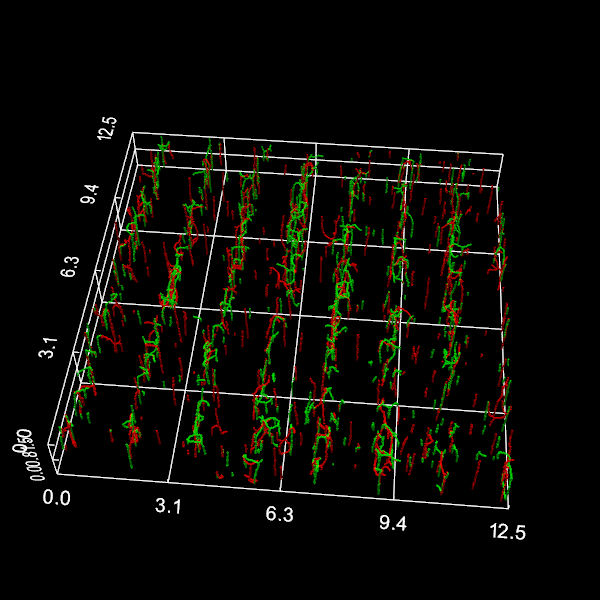

In [28]:
pl = pv.Plotter(notebook=True, window_size=(600, 600))
actor = pl.add_mesh(
    skeleton_desmin_voxels,
    cmap=["#FF0000"],
    show_scalar_bar=False,
)
actor = pl.add_mesh(
    skeleton_actinin_voxels,
    cmap=["#00FF00"],
    show_scalar_bar=False,
)
pl.set_background("black")
# pl.view_xy()
axis = pl.show_bounds(
    color="white",
    # bounds=[0.0, 8.0, 0.0, 8.0, 0.0, 2.0],
    grid="back",
    bold=False,
    font_size=15,
    location="outer",
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    n_zlabels=3,
    # show_zaxis=False,
    xtitle="",
    ytitle="",
    ztitle="",
    ticks="inside",
)
pl.camera.azimuth = 230
pl.camera.elevation = 15
# pl.camera.zoom(0.8)
pl.show()
pl.save_graphic("../figures/fig_4/4c.svg")

In [9]:
thresholds

NameError: name 'thresholds' is not defined